In [1]:
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt

from streamtomocupy import config
from streamtomocupy import streamrecon
from streamtomocupy import find_center_vo

%matplotlib inline


In [2]:
def get_data_pars(args, proj, flat, dark):
    '''Get parameters of the data'''

    args.nproj = proj.shape[0]
    args.nz = proj.shape[1]
    args.n = proj.shape[2]
    args.nflat = flat.shape[0]
    args.ndark = dark.shape[0]
    args.in_dtype = proj.dtype    
    return args        

### init parameters with default values. can be done ones and then commented

In [3]:
# config.write_args('test.conf')

## file test.conf can be edited to adjust reconstruction parameters as in tomocupy

In [4]:
# read parameters
args = config.read_args('test.conf')

## read data and set data sizes and dtype

In [5]:
with h5py.File('test_data.h5','r') as fid:
    proj = fid['exchange/data'][:]
    flat = fid['exchange/data_white'][:]
    dark = fid['exchange/data_dark'][:]
    theta = fid['exchange/theta'][:]/180*np.pi

args = get_data_pars(args,proj, flat, dark)

### find rotation axis automatically (if needed)

In [6]:
center_search_width = 100
center_search_step = 0.5
center_search_ind = proj.shape[1]//2
args.rotation_axis = find_center_vo(proj[:,center_search_ind], dark[:,center_search_ind], flat[:,center_search_ind],
                                    smin=-center_search_width, 
                                    smax=center_search_width, 
                                    step=center_search_step)
print('auto rotation axis',args.rotation_axis)


auto rotation axis 784.0


### create streaming reconstruction class, which involves allocation of pinned and gpu memory buffers, creating streams for several gpus

In [7]:
t = time.time()
cl_recstream = streamrecon.StreamRecon(args)
print('Create class, time', time.time()-t)

class created
Create class, time 2.489757776260376


## res array contains intermediate reconstruction resutls on cpu
#### res[0] - result of the first step, processing by sinogram chunks
#### res[1] - result of the sectond step, processing by projection chunks
#### res[2] - result of the third step, reconstruction by sinogram chunks

In [8]:
res = cl_recstream.get_res()

## Example 1. Full reconstruction by sinogram chunks 

In [ ]:
t = time.time()
cl_recstream.rec(proj, dark, flat, theta)
print('Reconstruction by sinogram chunks, time', time.time()-t)

9.739958e-05
9.441634e-05
9.975161e-05
9.662691e-05
0.00010432023
0.00010144432
0.000112669084
0.000108984925
0.00012717716
0.00012348476
0.0001522587
0.00014470301
0.00019481422
0.00018956113
4.541265e-06 3244.564 3244.564
1.7192588e-07 46.732567 46.732567
0.00010923331 2554.124 2554.124
8.227546e-05 2562.6904 2562.6904
1.0283303e-06 31.440746 31.440746
7.090312e-05 2134.098 2134.098
0.00010322671 2138.8418 2138.8418
1.7663712e-06 30.506798 30.5068
8.151531e-05 1888.0016 1888.0016
6.685195e-05 1881.126 1881.126
1.1205407e-06 33.25663 33.25663
6.620121e-05 1741.4115 1741.4115
7.1643466e-05 1737.3652 1737.3652
1.195262e-06 27.137764 27.137764
6.538951e-05 1662.8932 1662.8932
6.852394e-05 1660.4811 1660.4811
1.081275e-06 24.113247 24.113247
6.525314e-05 1621.9268 1621.9268
6.634328e-05 1621.2803 1621.2803
1.9236193e-06 43.579803 43.579803
6.582975e-05 1602.092 1602.092
9.78307e-05
9.496757e-05
0.000100466685
9.722116e-05
0.000104749946
0.00010168669
0.00011291175
0.00010981487
0.00013018

norm of the result 6.0023603


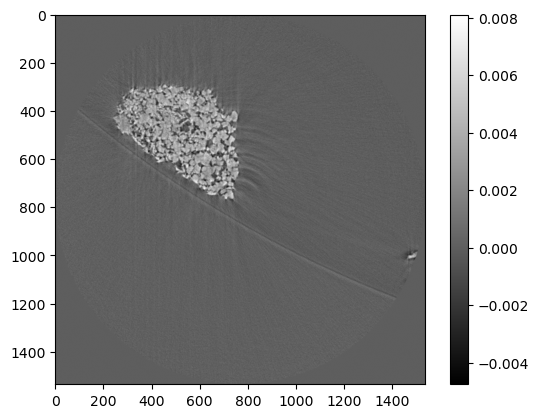

In [10]:
print('norm of the result', np.linalg.norm(res[2].astype('float32')))
plt.imshow(res[2][0],cmap='gray')
plt.colorbar()
plt.show()

## Example 2. Full reconstruction by sinogram and projection chunks 

In [11]:
args.retrieve_phase_method='paganin'
# processing and reconstruction
t = time.time()
cl_recstream.rec_steps(proj, dark, flat, theta)
print('Reconstruction by sinogram and projection chunks, time', time.time()-t)


9.739958e-05
9.441634e-05
9.975161e-05
9.662691e-05
0.00010432023
0.00010144432
0.000112669084
0.000108984925
0.00012717716
0.00012348476
0.0001522587
0.00014470301
0.00019481422
0.00018956113
4.541265e-06 3244.564 3244.564
1.7192588e-07 46.732567 46.732567
0.00010923331 2554.124 2554.124
8.227546e-05 2562.6904 2562.6904
1.0283303e-06 31.440746 31.440746
7.090312e-05 2134.098 2134.098
0.00010322671 2138.8418 2138.8418
1.7663712e-06 30.506798 30.5068
8.151531e-05 1888.0016 1888.0016
6.685195e-05 1881.126 1881.126
1.1205407e-06 33.25663 33.25663
6.620121e-05 1741.4115 1741.4115
7.164297e-05 1737.3652 1737.3652
1.1952465e-06 27.137764 27.137764
6.5389184e-05 1662.8932 1662.8932
6.852451e-05 1660.4811 1660.4811
1.0810452e-06 24.113247 24.113247
6.52586e-05 1621.9268 1621.9268
6.636636e-05 1621.2803 1621.2803
1.9232634e-06 43.579803 43.579803
6.583308e-05 1602.092 1602.092
9.78307e-05
9.496757e-05
0.000100466685
9.722116e-05
0.000104749946
0.00010168669
0.00011291175
0.00010981487
0.0001301

norm of the result 4.787582


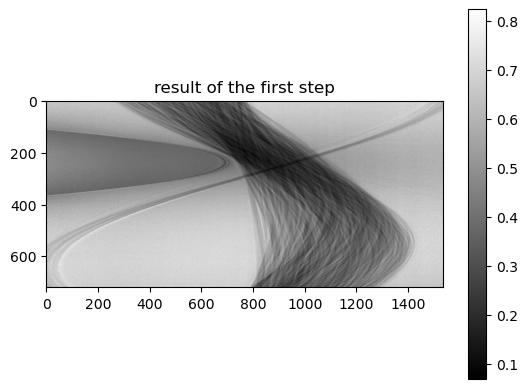

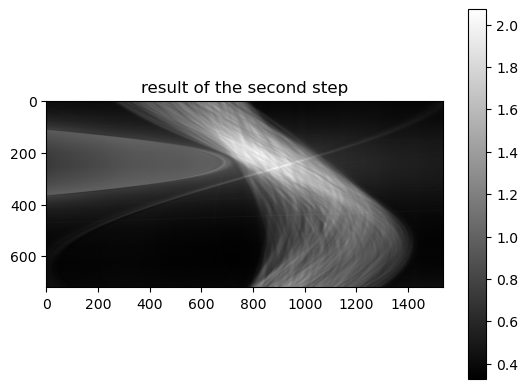

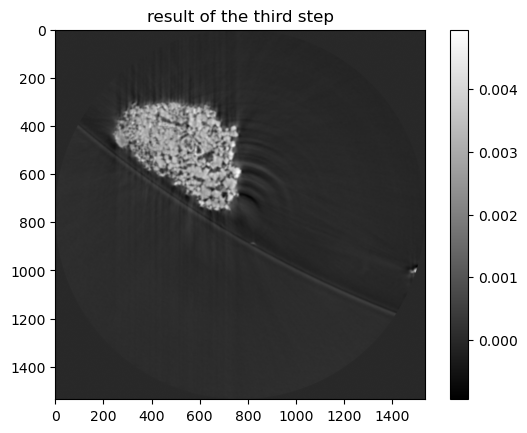

In [12]:
print('norm of the result', np.linalg.norm(res[2].astype('float32')))
plt.imshow(res[0][:,0],cmap='gray')
plt.title('result of the first step')
plt.colorbar()
plt.show()

plt.imshow(res[1][:,res[1].shape[1]//2],cmap='gray')
plt.title('result of the second step')
plt.colorbar()
plt.show()

plt.imshow(res[2][res[2].shape[0]//2],cmap='gray')
plt.title('result of the third step')
plt.colorbar()
plt.show()

## Example 3. Full reconstruction by sinogram and projection chunks, manual selection of slices 

In [13]:
st = 4
end = 11
args.rotation_axis = -1
t =time.time()
cl_recstream.proc_sino(res[0][:,st:end], proj[:,st:end], dark[:,st:end], flat[:,st:end])
cl_recstream.proc_proj(res[1][:,st:end], res[0][:,st:end])
cl_recstream.rec_sino(res[2][st:end], res[1][:,st:end], theta)
print('Manual processing and reconstruction by sinogram and projection chunks, time', time.time()-t)
print('norm of the result', np.linalg.norm(res[2][st:end].astype('float32')))

6281.2856
6445.5537
6274.7754
7062.4766
7944.6416
8218.851
9184.544
9279.032
11827.996
10931.498
12062.433
11283.851
15009.352
12930.011
562.13513 231325830000.0 231325830000.0
161.71396 24852136000.0 24852136000.0
10383.29 164899670000.0 164899680000.0
5081.758 216085890000.0 216085890000.0
668.97864 28654074000.0 28654074000.0
293.295 155492160000.0 155492160000.0
8796.706 165495470000.0 165495470000.0
5711.8267 112443250000.0 112443250000.0
10185.237 146469550000.0 146469570000.0
4071.1042 146450760000.0 146450760000.0
2042.7477 74046930000.0 74046930000.0
60.09729 116457080000.0 116457080000.0
5611.7935 120140825000.0 120140825000.0
2838.9429 58870542000.0 58870542000.0
50.514935 94651790000.0 94651790000.0
3970.819 98214330000.0 98214330000.0
2606.2473 54166790000.0 54166790000.0
193.9637 79267865000.0 79267865000.0
4479.8994 83515965000.0 83515960000.0
3281.741 65056195000.0 65056195000.0
3864.2903 74856350000.0 74856350000.0
Manual processing and reconstruction by sinogram and p

## Example 4. Rotation center search, after processing

9.739958e-05
9.441634e-05
9.975161e-05
9.662691e-05
0.00010432023
0.00010144432
0.000112669084
0.000108984925
0.00012717716
0.00012348476
0.0001522587
0.00014470301
0.00019481422
0.00018956113
4.541265e-06 3244.564 3244.564
1.7192588e-07 46.732567 46.732567
0.00010923331 2554.124 2554.124
8.227546e-05 2562.6904 2562.6904
1.0283303e-06 31.440746 31.440746
7.090312e-05 2134.098 2134.098
0.00010322671 2138.8418 2138.8418
1.7663712e-06 30.506798 30.5068
8.151531e-05 1888.0016 1888.0016
6.685195e-05 1881.126 1881.126
1.1205407e-06 33.25663 33.25663
6.620121e-05 1741.4115 1741.4115
7.164466e-05 1737.3652 1737.3652
1.1954653e-06 27.137764 27.137764
6.538886e-05 1662.8932 1662.8932
6.8595145e-05 1660.4811 1660.4811
1.0808232e-06 24.113247 24.113247
6.5261025e-05 1621.9268 1621.9268
6.6389184e-05 1621.2803 1621.2803
1.923626e-06 43.579803 43.579803
6.583167e-05 1602.092 1602.092
9.78307e-05
9.496757e-05
0.000100466685
9.722116e-05
0.000104749946
0.00010168669
0.00011291175
0.00010981487
0.00013

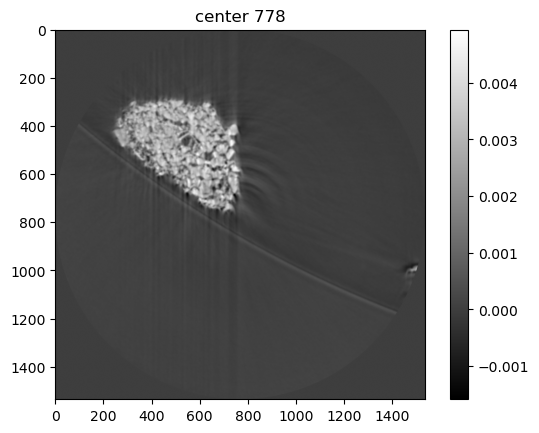

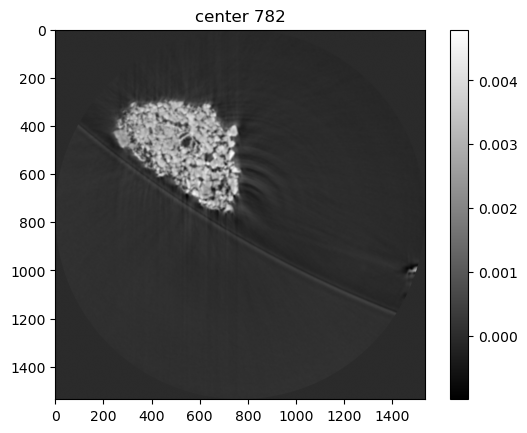

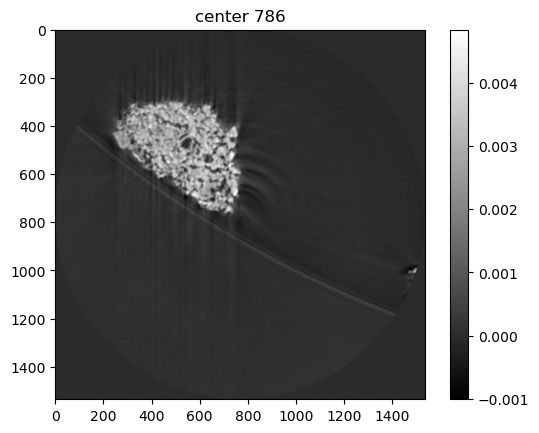

In [14]:
cl_recstream.proc_sino(res[0], proj, dark, flat)
cl_recstream.proc_proj(res[1], res[0])

st = 4
end = 5
for k in range(0,12,4):
    args.rotation_axis = 784+k-6
    cl_recstream.rec_sino(res[2][k:k+1], res[1][:,st:end], theta)

for k in range(0,12,4):
    plt.title(f'center {784+k-6}')
    plt.imshow(res[2][k],cmap='gray')
    plt.colorbar()
    plt.show()


## Example 5. Phase retrieval parameter search

9.739958e-05
9.441634e-05
9.975161e-05
9.662691e-05
0.00010432023
0.00010144432
0.000112669084
0.000108984925
0.00012717716
0.00012348476
0.0001522587
0.00014470301
0.00019481422
0.00018956113
4.541265e-06 3244.564 3244.564
1.7192588e-07 46.732567 46.732567
0.00010923331 2554.124 2554.124
8.227546e-05 2562.6904 2562.6904
1.0283303e-06 31.440746 31.440746
7.090312e-05 2134.098 2134.098
0.00010322671 2138.8418 2138.8418
1.7663712e-06 30.506798 30.5068
8.151531e-05 1888.0016 1888.0016
6.685195e-05 1881.126 1881.126
1.1205407e-06 33.25663 33.25663
6.620121e-05 1741.4115 1741.4115
7.164297e-05 1737.3652 1737.3652
1.1955782e-06 27.137764 27.137764
6.538875e-05 1662.8932 1662.8932
6.838102e-05 1660.4811 1660.4811
1.0811314e-06 24.113247 24.113247
6.525645e-05 1621.9268 1621.9268
6.64203e-05 1621.2803 1621.2803
1.924025e-06 43.579803 43.579803
6.5829634e-05 1602.092 1602.092
9.78307e-05
9.496757e-05
0.000100466685
9.722116e-05
0.000104749946
0.00010168669
0.00011291175
0.00010981487
0.00013018

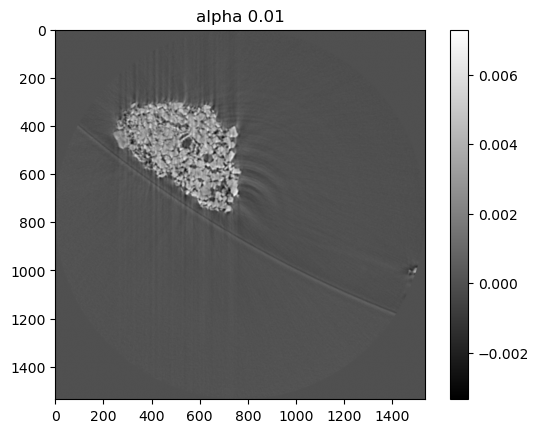

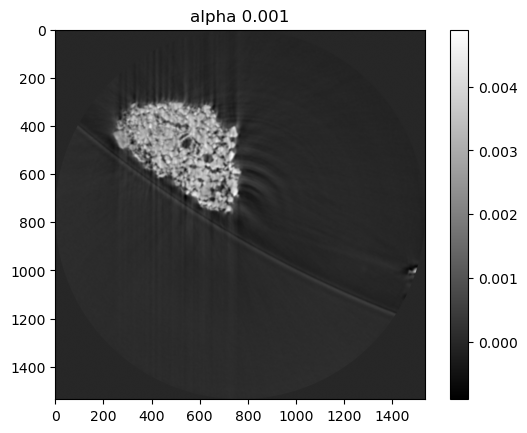

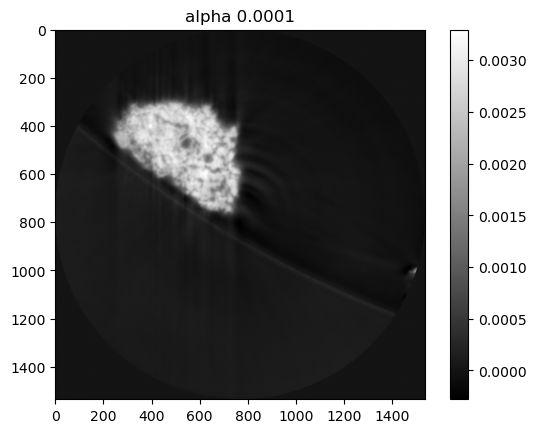

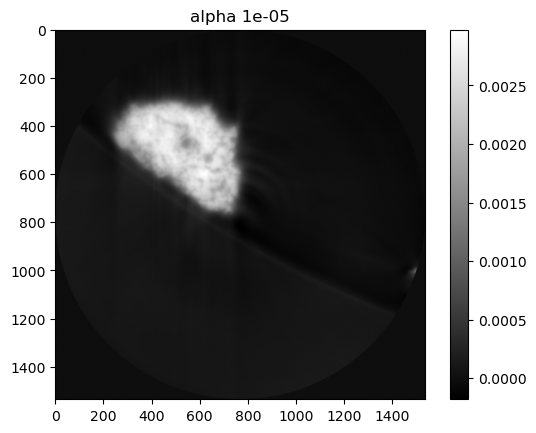

In [15]:
cl_recstream.proc_sino(res[0], proj, dark, flat)
args.retrieve_phase_method = 'paganin'
st = 5
end = 6
for k in range(4):
    args.retrieve_phase_alpha = 10**(-k-2)
    cl_recstream.proc_proj(res[1], res[0])
    cl_recstream.rec_sino(res[2][k:k+1], res[1][:,st:end], theta)

   
for k in range(4):
    plt.title(f'alpha {10**(-k-2)}')
    plt.imshow(res[2][k],cmap='gray')
    plt.colorbar()
    plt.show()
